In [1]:
import neptune as neptune
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.ticker as mticker

from misc import (
    plot_module,
    plot_multiple_modules,
    get_steps_from_first_run,
    pivot_dict,
    plot_loss_vs_lr,
)

## Neptune

In [12]:
def get_neptune_table(tags, negative_tags=None, columns=None):
    """
    Fetches a Neptune runs table filtered by tags and returns it as a pandas DataFrame.

    Parameters:
    - tags (list): List of tags to filter the runs.
    - negative_tags (list, optional): List of tags to exclude from the runs.
    - columns (list, optional): Additional columns to include in the runs table.

    Returns:
    - pandas.DataFrame: The runs table with the specified filters and columns.
    """

    # Initialize the Neptune project
    project = neptune.init_project(
        project="pmtest/llm-random",
        mode="read-only",
        api_token=os.environ["NEPTUNE_API_TOKEN"],
    )

    # Fetch the runs table with the specified tags and columns
    runs_table = project.fetch_runs_table(tag=tags, columns=columns).to_pandas()

    # Ensure 'sys/tags' is a list for each run
    # print(f"runs_table: {runs_table}")
    runs_table["sys/tags"] = runs_table["sys/tags"].apply(
        lambda x: x.split(",") if isinstance(x, str) else x
    )

    # Exclude runs containing any of the negative tags
    if negative_tags:
        for neg_tag in negative_tags:
            runs_table = runs_table[
                ~runs_table["sys/tags"].apply(lambda x: neg_tag in x)
            ]

    print(f"Table downloaded\nShape: {runs_table.shape}")
    return runs_table


def get_activations(runs_table, n_steps):
    activation_dict = {}
    for i, run_row in runs_table.iterrows():
        # dmodel = 2 ** (i + 4)
        dmodel = run_row["args/dmodel"]
        run_id = run_row["sys/id"]  # Assuming 'sys/id' is the run identifier
        print(f"run ID: {run_id}, last_step: {run_row['step']}")
        if run_row['step'] == n_steps:
            project_name = "pmtest/llm-random"
            # run_id = "LLMRANDOM-2078"
            run = neptune.init_run(
                project=project_name,
                with_id=run_id,
                mode="read-only",
                api_token=os.environ["NEPTUNE_API_TOKEN"],
            )
            print(f'run keys\n{run["block_0/residual_attention"]}')
            single_run_data = {"dmodel": dmodel}
            print(f'n_blocks: {run["args/n_blocks"].fetch()}')
            for i in range(run["args/n_blocks"].fetch()):
                single_run_data[i] = {
                    "attn": run[
                        f"block_{i}/residual_attention/muP/mean_abs_update"
                    ].fetch_values(),
                    "FF": run[
                        f"block_{i}/residual_feedforward/muP/mean_abs_update"
                    ].fetch_values(),
                }
            try:
                single_run_data["UNKNOWN"] = {
                    "embedding": run[
                        f"block_UNKNOWN/embedding_layer/muP/mean_abs_update"
                    ].fetch_values(),
                    "head": run[f"block_UNKNOWN/head/muP/mean_abs_update"].fetch_values(),
                }
            except Exception as e:
                print(f"Unexpected error: {e.__class__.__name__} - {e}")
                single_run_data["UNKNOWN"] = {
                    "embedding": run[
                        f"block_UNKNOWN/_fsdp_wrapped_module.embedding_layer/muP/mean_abs_update"
                    ].fetch_values(),
                    "head": run[f"block_UNKNOWN/_fsdp_wrapped_module.head/muP/mean_abs_update"].fetch_values(),
                }
            activation_dict[run_id] = single_run_data
    return activation_dict

## Plot

https://app.neptune.ai/pmtest/llm-random/
Table downloaded
Shape: (36, 431)
(36, 431)
[6.21      5.8465625 5.385     5.1390625 5.00625   4.9878125 5.08125
 6.145625  5.3371875]
[5.880625  5.4396875 5.016875  4.8040625 4.689375  4.7328125 4.931875
 4.99125   5.255625 ]
[5.4784375 5.066875  4.638125  4.479375  4.471875  4.6071875 4.780625
 5.091875  5.3609375]
[5.060625  4.698125  4.374375  4.344375  4.38625   4.654375  4.9384375
 5.158125  5.82125  ]


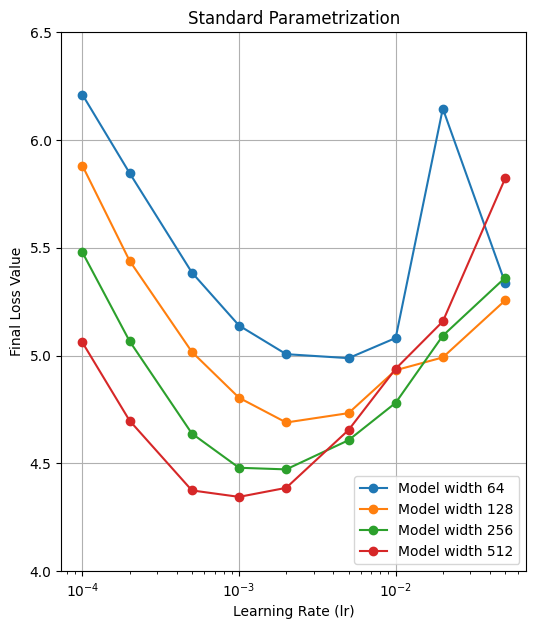

In [3]:
tags = ["muP_MoE", "muTransfer", "kc_version_3_moe", "lr_plot_moe"]
# tags = ["muP_MoE", "muTransfer", "kc_reference_grid", "kc_version_3", "like_blog"]

df = get_neptune_table(tags)
print(df.shape)
plot_loss_vs_lr(df, (4, 6.5), figsize=(6, 7), title="Standard Parametrization")

In [4]:
tags = ["muP_MoE", "muTransfer", "kc_version_3_moe", "lr_plot_moe_mup"]
# tags = ["muP_MoE", "muTransfer", "kc_mup_extrapolation", "kc_version_3", "extrapol_2", "weight_decay=0.01",]

df = get_neptune_table(tags)
print(df.shape)

https://app.neptune.ai/pmtest/llm-random/


Table downloaded
Shape: (36, 435)
(36, 435)


[ 6.585625   6.2390625  5.781875   5.4421875  5.1803125  4.9996875
  4.983125  31.235      5.77125  ]
[6.430625  6.098125  5.565     5.2278125 4.92875   4.68125   4.6325
 4.789375  5.7921875]
[6.345     5.9790625 5.4315625 5.058125  4.7465625 4.46375   4.3940625
 4.4296875 4.746875 ]
[6.2521875 5.8871875 5.32375   4.9678125 4.633125  4.411875  4.325
 4.306875  4.6190625]


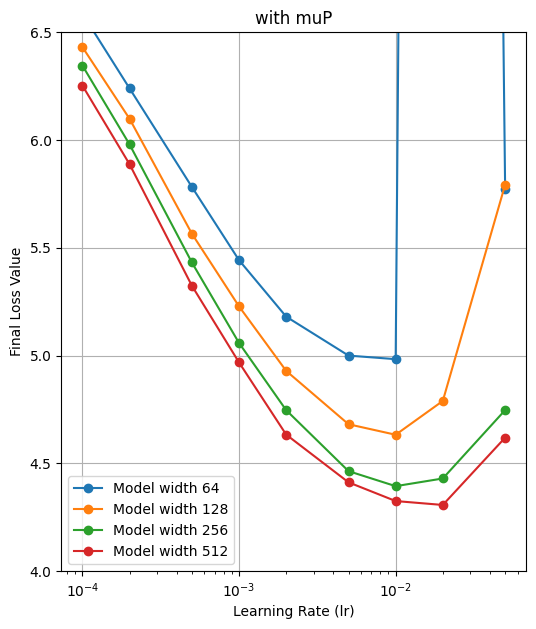

In [5]:
plot_loss_vs_lr(df, (4, 6.5), figsize=(6, 7), title="with muP")

In [23]:
# tags = ['muP_MoE', 'extrapolation']
# tags = ['muP_MoE', 'mup_grid_2', 'weight_decay=0.01', 'learning_rate=1e-2']
tags = [
    "muP_MoE",
    "muTransfer",
    "10_step_new",
]

df = get_neptune_table(tags)
print(df.shape)

https://app.neptune.ai/pmtest/llm-random/
Table downloaded
Shape: (25, 407)
(25, 407)


In [24]:
act_dict = get_activations(df, n_steps=10)
print(act_dict)

run ID: LLMRANDOM-30700, last_step: 10.0
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-30700
run keys
<Namespace field at "block_0/residual_attention">
n_blocks: 2
run ID: LLMRANDOM-30699, last_step: 10.0
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-30699
run keys
<Namespace field at "block_0/residual_attention">
n_blocks: 2
run ID: LLMRANDOM-30698, last_step: 10.0
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-30698
run keys
<Namespace field at "block_0/residual_attention">
n_blocks: 2
run ID: LLMRANDOM-30696, last_step: 10.0
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-30696
run keys
<Namespace field at "block_0/residual_attention">
n_blocks: 2
run ID: LLMRANDOM-30695, last_step: 10.0
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-30695
run keys
<Namespace field at "block_0/residual_attention">
n_blocks: 2
run ID: LLMRANDOM-30694, last_step: 10.0
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-30694
run keys
<Namespace field at "block_0/residua

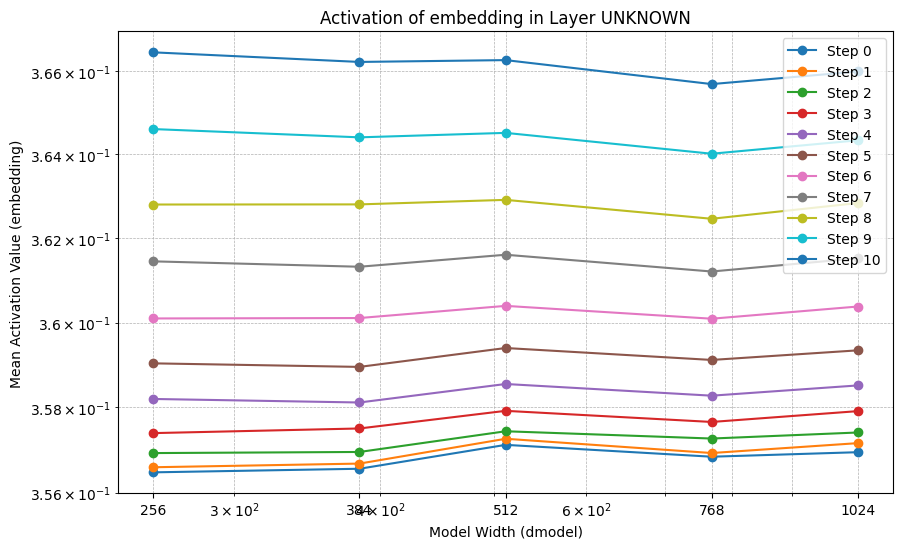

In [28]:
steps = get_steps_from_first_run(act_dict)
layer_num = "UNKNOWN"
module = "embedding"
dmodels = [256, 384, 512, 768, 1024]
# layer_num = 3
# module='FF'
pivoted_dict = pivot_dict(
    activations_dict=act_dict,
    steps=steps,
    dmodels=dmodels,
    layer_num=layer_num,
    module=module,
)
plot_module(
    pivoted_dict=pivoted_dict,
    module_keyword=module,
    layer_num=layer_num,
    step_interval=1,
)

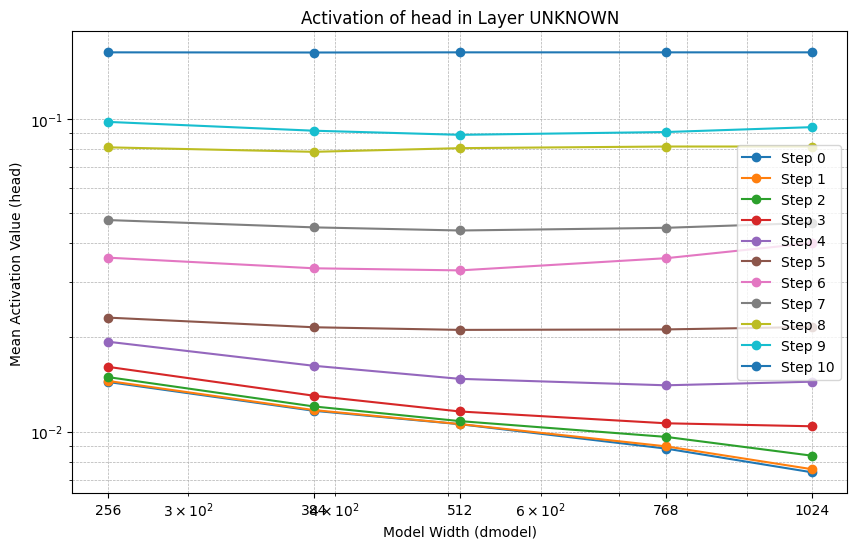

In [29]:
layer_num = "UNKNOWN"
module = "head"
pivoted_dict = pivot_dict(
    activations_dict=act_dict,
    steps=steps,
    dmodels=dmodels,
    layer_num=layer_num,
    module=module,
)
plot_module(
    pivoted_dict=pivoted_dict,
    module_keyword=module,
    layer_num=layer_num,
    step_interval=1,
)

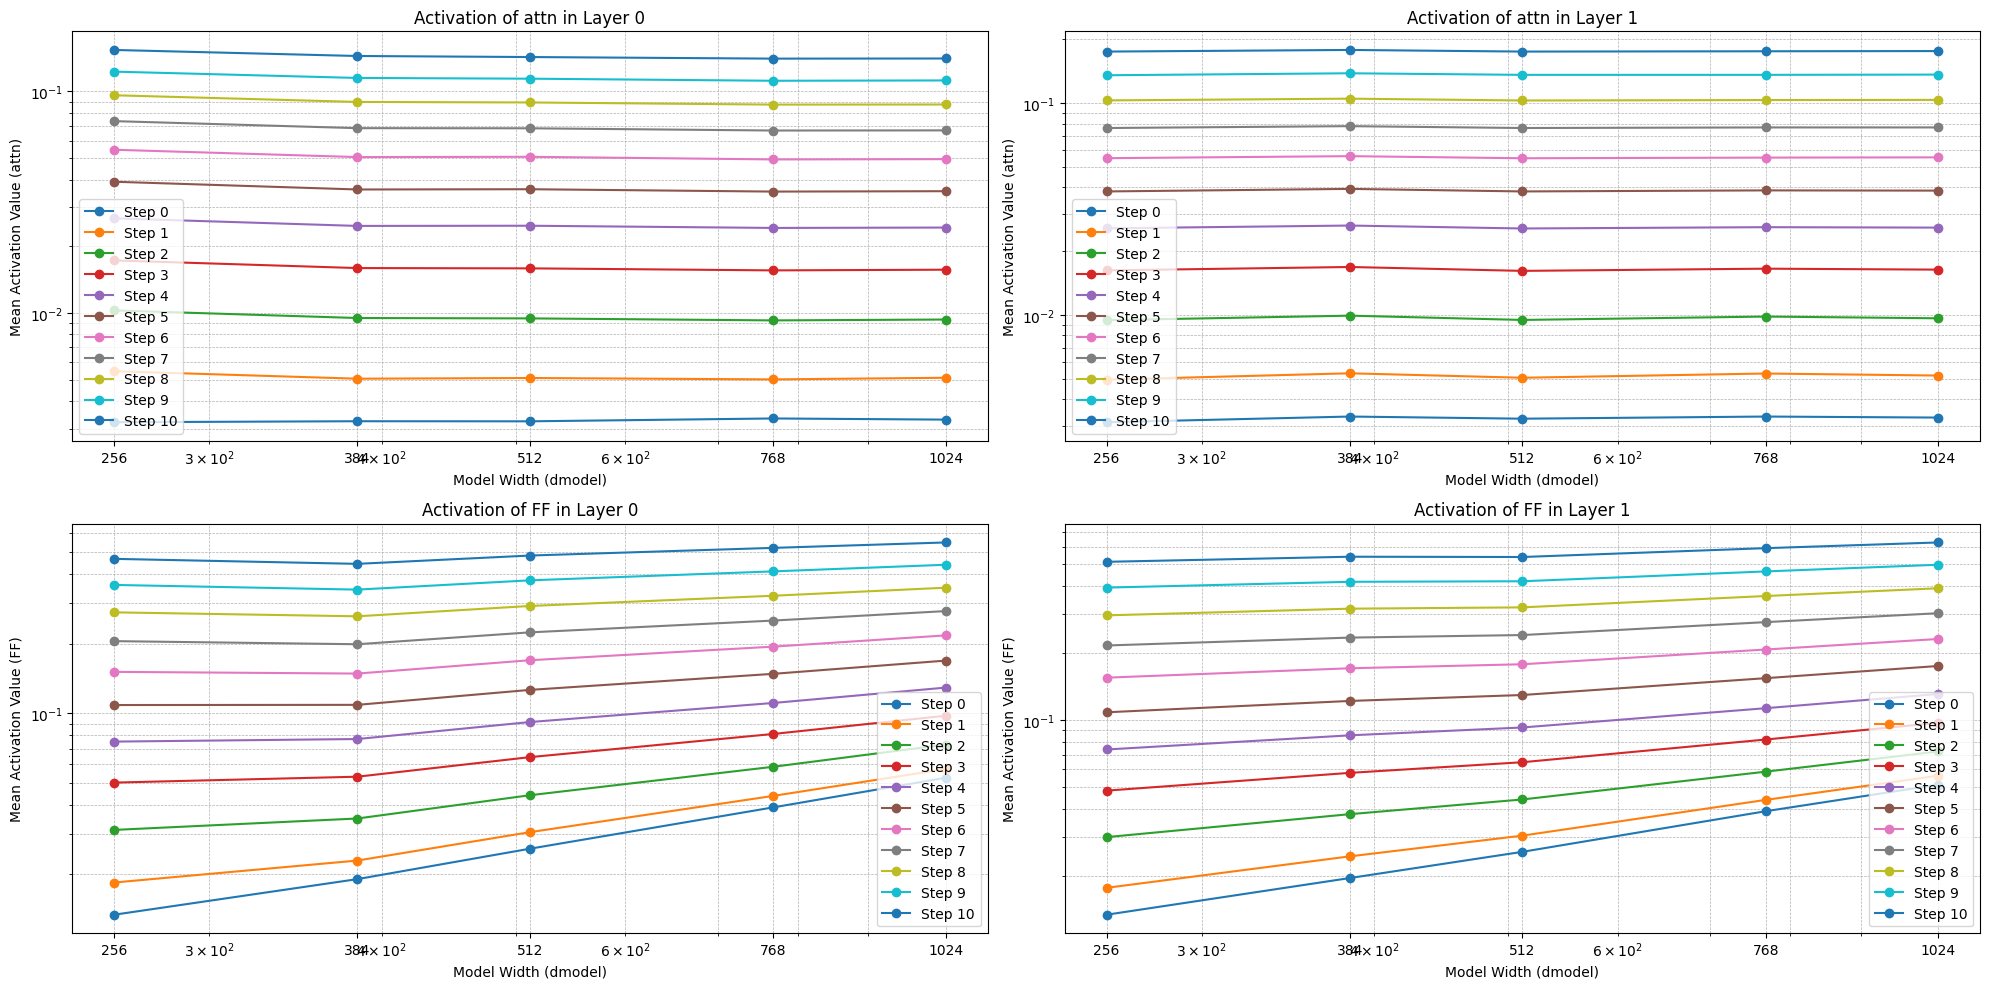

In [30]:
plot_multiple_modules(
    activations_dict=act_dict,
    module_keywords=["attn", "FF"],
    layer_nums=[0, 1],
    step_interval=1,
    figsize=(20, 10),
    dmodels=dmodels,
)

In [ ]:
import torch


def truncated_normal_(tensor, mean=0.0, std=1.0, lower=-2.0, upper=2.0):
    """
    Initializes a tensor with truncated normal distribution.

    Args:
        tensor (torch.Tensor): Tensor to be initialized.
        mean (float): Mean of the normal distribution.
        std (float): Standard deviation of the normal distribution.
        lower (float): Lower bound of truncation.
        upper (float): Upper bound of truncation.
    """
    # Calculate the bounds in standard deviations
    lower_bound = (lower - mean) / std
    upper_bound = (upper - mean) / std

    # Use torch's trunc_normal_ if available
    with torch.no_grad():
        size = tensor.shape
        truncated = torch.fmod(
            torch.normal(mean=mean, std=std, size=size), upper_bound - lower_bound
        )
        tensor.copy_(torch.clamp(truncated, min=lower, max=upper))


# Example usage
v = 100
d = 5
x = torch.zeros(v)
x[5] += 1.0
print(f"x[:10] = {x[:10]}")
matrix = torch.empty(v, d)  # Create an empty 5x5 tensor
std_base = 1.0
truncated_normal_(matrix, mean=0.0, std=std_base, lower=-2.0, upper=2.0)
print(f"base norm: {torch.norm(x@matrix)/np.sqrt(d)}\tstd: {torch.std(x@matrix)}")

e = 1000
# x = torch.rand(v)
matrix = torch.empty(v, e)  # Create an empty 5x5 tensor
m_d = e / d
truncated_normal_(matrix, mean=0.0, std=std_base, lower=-2.0, upper=2.0)
# matrix *= (1 / np.sqrt(m_d))
print(f"extrpl norm: {torch.norm(x@matrix)/np.sqrt(e)}\tstd: {torch.std(x@matrix)}")

x[:10] = tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])
base norm: 1.2175053358078003	std: 1.2705504894256592
extrpl norm: 0.9404301643371582	std: 0.9408999681472778


In [ ]:
def grid_time(exp_time, num_exps, num_gpus):
    grid_time_on_1_gpu = exp_time * num_exps
    print(f"grid_time_on_1_gpu: {grid_time_on_1_gpu}")
    total_time = grid_time_on_1_gpu / num_gpus
    return total_time


exp_time = 3.5 / 60
num_exps = 6 * 5**3
num_gpus = 8

print(f"num exps: {num_exps}")
total_time = grid_time(exp_time=exp_time, num_exps=num_exps, num_gpus=num_gpus)
print(f"grid time: {total_time:.2f} h")

num exps: 750
grid_time_on_1_gpu: 43.75
grid time: 5.47 h
